In [ ]:
# import basic libs
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from sklearn.preprocessing import LabelEncoder # label encoding
from sklearn.impute import KNNImputer # impute missing values using KNN
import seaborn as sns
from pandas.api.types import is_object_dtype  # excluding object cols for correlation plot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing # label encoding

In [ ]:
df = pd.read_csv('https://dev.km2.ai/public/parcels_last.csv', low_memory=False) # 1.5 Gb, 2488394 lines, ~3 minutes  

In [ ]:
df.head()

,id,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,...,UnitNo,City,ZIPcode5,rowID,CENTER_LAT,CENTER_LON,Location1,geo,RecordingDateYear,zip2
0,6985,,PALOS VERDES EST,7545002900,2012,7112,7545-002-900,NaN,OTH,8800,...,,,NaN,20127545002900,33.794278,-118.385681,"(33.79427793, -118.385681)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1967,NaN
1,7066,,PALOS VERDES EST,7545002010,2013,7112,7545-002-010,NaN,VAC,010V,...,,,NaN,20137545002010,0.000000,0.000000,NaN,bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2012,NaN
2,7432,,PALOS VERDES EST,7545002011,2013,7112,7545-002-011,NaN,VAC,010V,...,,,NaN,20137545002011,0.000000,0.000000,NaN,bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2012,NaN
3,7792,90274,PALOS VERDES EST,7545009022,2008,7112,7545-009-022,1108 VIA NOGALES PALOS VERDES EST CA 90274,VAC,010V,...,,PALOS VERDES EST CA,90274.0,20087545009022,33.791150,-118.393489,"(33.79114981, -118.3934893)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2005,90274.0
4,9019,90274,PALOS VERDES EST,7545017001,2006,7112,7545-017-001,2300 VIA FERNANDEZ PALOS VERDES EST CA 90274,SFR,0101,...,,PALOS VERDES EST CA,90274.0,20067545017001,33.790895,-118.390947,"(33.79089535, -118.39094711)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1994,90274.0


In [ ]:
df.shape

(2485732, 55)

In [ ]:
df.columns

Index(['id', 'ZIPcode', 'TaxRateArea_CITY', 'AIN', 'RollYear', 'TaxRateArea',
       'AssessorID', 'PropertyLocation', 'PropertyType', 'PropertyUseCode',
       'GeneralUseType', 'SpecificUseType', 'SpecificUseDetail1',
       'SpecificUseDetail2', 'totBuildingDataLines', 'YearBuilt',
       'EffectiveYearBuilt', 'SQFTmain', 'Bedrooms', 'Bathrooms', 'Units',
       'RecordingDate', 'LandValue', 'LandBaseYear', 'ImprovementValue',
       'ImpBaseYear', 'TotalLandImpValue', 'HomeownersExemption',
       'RealEstateExemption', 'FixtureValue', 'FixtureExemption',
       'PersonalPropertyValue', 'PersonalPropertyExemption', 'isTaxableParcel',
       'TotalValue', 'TotalExemption', 'netTaxableValue',
       'SpecialParcelClassification', 'AdministrativeRegion', 'Cluster',
       'ParcelBoundaryDescription', 'HouseNo', 'HouseFraction',
       'StreetDirection', 'StreetName', 'UnitNo', 'City', 'ZIPcode5', 'rowID',
       'CENTER_LAT', 'CENTER_LON', 'Location1', 'geo', 'RecordingDateYear',
    

### Data Preprocessing

#### EDA

In [ ]:
# reduce memory
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))   
    return df


data = reduce_mem_usage(df)

Memory usage of dataframe is 1043.05 MB
Memory usage after optimization is: 670.87 MB
Decreased by 35.7%


In [ ]:
# summary statistics
def describe(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary
describe(data)

Dataset Shape: (2485732, 55)


,Name,dtypes,Missing,Uniques
0,id,int32,0,2485732
1,ZIPcode,object,125248,461383
2,TaxRateArea_CITY,object,0,145
3,AIN,int64,0,2485732
4,RollYear,int16,0,16
5,TaxRateArea,int16,0,10422
6,AssessorID,object,0,2485732
7,PropertyLocation,object,147678,2261071
8,PropertyType,object,6026,7
9,PropertyUseCode,object,830,1199


#### Feature Selection

In [ ]:
# delete same rows
data = data.drop_duplicates()

In [ ]:
# filter the data with reasonability
data = data[data['GeneralUseType']=='Residential']
data = data[data['ZIPcode'].notna()]
# df = df[df['YearBuilt']>=1900]
data = data[data['TotalValue']>0]
data = data[data['SQFTmain']>0]

In [ ]:
data.shape

(2061636, 55)

In [ ]:
data

,id,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,...,UnitNo,City,ZIPcode5,rowID,CENTER_LAT,CENTER_LON,Location1,geo,RecordingDateYear,zip2
4,9019,90274,PALOS VERDES EST,7545017001,2006,7112,7545-017-001,2300 VIA FERNANDEZ PALOS VERDES EST CA 90274,SFR,0101,...,,PALOS VERDES EST CA,90274.0,20067545017001,33.78125,-118.3750,"(33.79089535, -118.39094711)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1994,90274.0
5,9465,90274-2030,PALOS VERDES EST,7545017026,2015,7112,7545-017-026,2417 VIA SONOMA PALOS VERDES EST CA 90274,SFR,0101,...,,PALOS VERDES EST CA,90274.0,20157545017026,33.78125,-118.3750,"(33.78986567, -118.38917702)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2009,90274.0
6,9546,90274,PALOS VERDES EST,7545017035,2006,7112,7545-017-035,2228 VIA FERNANDEZ PLS VRDS EST CA 90274,SFR,0100,...,,PLS VRDS EST CA,90274.0,20067545017035,33.78125,-118.3750,"(33.79063028, -118.39079975)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2002,90274.0
11,14197,90275,RANCHO PALOS VER,7546008022,2012,7091,7546-008-022,5325 IRONWOOD ST RANCHO PALOS VERDES CA 90275,SFR,0100,...,,RANCHO PALOS VERDES CA,90275.0,20127546008022,33.78125,-118.3750,"(33.79081275, -118.3708079)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1997,90275.0
14,15394,90275,RANCHO PALOS VER,7546012036,2009,7096,7546-012-036,3340 VIA CAMPESINA RANCHO PALOS VERDES CA 90275,SFR,0100,...,,RANCHO PALOS VERDES CA,90275.0,20097546012036,33.78125,-118.3750,"(33.79339868, -118.37305487)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1989,90275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485724,40413902,90274-1229,PALOS VERDES EST,7540009006,2015,7112,7540-009-006,521 VIA ALMAR PALOS VERDES EST CA 90274,SFR,0100,...,,PALOS VERDES EST CA,90274.0,20157540009006,33.81250,-118.3750,"(33.79946812, -118.40102118)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2014,90274.0
2485725,40417145,90274,PALOS VERDES EST,7541001019,2007,7112,7541-001-019,1017 PALOS VERDES DR W PALOS VERDES EST CA 9...,SFR,0100,...,,PALOS VERDES EST CA,90274.0,20077541001019,33.78125,-118.4375,"(33.7921642, -118.40734835)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1988,90274.0
2485726,40417865,90274,PALOS VERDES EST,7541001006,2012,7112,7541-001-006,1101 PALOS VERDES DR W PALOS VERDES EST CA 9...,SFR,0100,...,,PALOS VERDES EST CA,90274.0,20127541001006,33.78125,-118.3750,"(33.79159175, -118.40536444)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1986,90274.0
2485727,40421642,90274-1927,PALOS VERDES EST,7541030003,2015,7112,7541-030-003,1609 VIA GARFIAS PALOS VERDES EST CA 90274,SFR,0100,...,,PALOS VERDES EST CA,90274.0,20157541030003,33.78125,-118.4375,"(33.78360478, -118.40993617)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2011,90274.0


#### Missing Values

In [ ]:
# identify columns with missing values
data_null = data.isnull().sum() / len(data) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio (%)': data_null})
missing_data

,Missing Ratio (%)
SpecialParcelClassification,99.209317
HouseFraction,99.028490
UnitNo,86.223077
SpecificUseDetail1,85.842069
StreetDirection,72.997998
SpecificUseDetail2,66.631791
Location1,0.042491
ZIPcode5,0.011205
zip2,0.011205
PropertyLocation,0.011059


1. Drop 2 columns that is almost have no value (with 99% missing ratio)

In [ ]:
# drop 2 columns that is almost have no value (with 99% missing ratio)
dropped_cols = [i for i in data.columns if data[i].isnull().sum() / len(data) > 0.99]
data.drop(dropped_cols, axis=1, inplace=True)

In [ ]:
data.shape

(2061636, 53)

2. Deal with UnitNo & StreetDirection (Setting Dummy Variables)

In [ ]:
data['UnitNo1'] = data['UnitNo'].apply(lambda x: 0 if str(x).isspace() or x is np.nan else 1)  # 0 if no value; 1 if UnitNo has value (text or number)

In [ ]:
data.shape

(2061636, 54)

In [ ]:
data.columns[-1]  # 不知道为什么columns里有，但是shape没加上去

'UnitNo1'

In [ ]:
1 - data['UnitNo1'].sum()/data.shape[0]  # 比上面稍多一些些，可能是有些是空格

0.8697345215159223

In [ ]:
data[['UnitNo', 'UnitNo1']].iloc[775:785]

,UnitNo,UnitNo1
2604,,0
2606,,0
2607,,0
2609,APT D,1
2610,,0
2612,21,1
2618,,0
2630,,0
2632,,0
2634,,0


In [ ]:
data['StreetDirection1'] = data['StreetDirection'].apply(lambda x: 0 if str(x).isspace() or x is np.nan else 1)  # 0 if no value; 1 if UnitNo has value (text or number)

In [ ]:
1 - data['StreetDirection1'].sum()/data.shape[0]

0.7357069822218859

In [ ]:
data.shape

(2061636, 55)

In [ ]:
data.drop(['UnitNo', 'StreetDirection'], axis=1, inplace=True)

In [ ]:
data.shape

(2061636, 53)

3. Drop SpecificUseDetail1&2

In [ ]:
data.drop(['SpecificUseDetail1', 'SpecificUseDetail2'], axis=1, inplace=True)

In [ ]:
data.shape

(2061636, 51)

4. Keep only 1 column of ZIP Codes

In [ ]:
# Keep 1 zipcode cols with minimal missing values ----> According to missing ratio df, we keep ZIPcode
data.drop(["ZIPcode5", "zip2"], axis=1, inplace=True)

In [ ]:
data.shape

(2061636, 49)

5. Drop rows with missing values

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(2060530, 49)

In [ ]:
set(df.columns).difference(set(data.columns))

{'HouseFraction',
 'SpecialParcelClassification',
 'SpecificUseDetail1',
 'SpecificUseDetail2',
 'StreetDirection',
 'UnitNo',
 'ZIPcode5',
 'zip2'}

In [ ]:
set(data.columns).difference(set(df.columns))

{'StreetDirection1', 'UnitNo1'}

In [ ]:
data

,id,ZIPcode,TaxRateArea_CITY,AIN,RollYear,TaxRateArea,AssessorID,PropertyLocation,PropertyType,PropertyUseCode,...,StreetName,City,rowID,CENTER_LAT,CENTER_LON,Location1,geo,RecordingDateYear,UnitNo1,StreetDirection1
4,9019,90274,PALOS VERDES EST,7545017001,2006,7112,7545-017-001,2300 VIA FERNANDEZ PALOS VERDES EST CA 90274,SFR,0101,...,VIA FERNANDEZ,PALOS VERDES EST CA,20067545017001,33.78125,-118.3750,"(33.79089535, -118.39094711)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1994,0,0
5,9465,90274-2030,PALOS VERDES EST,7545017026,2015,7112,7545-017-026,2417 VIA SONOMA PALOS VERDES EST CA 90274,SFR,0101,...,VIA SONOMA,PALOS VERDES EST CA,20157545017026,33.78125,-118.3750,"(33.78986567, -118.38917702)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2009,0,0
6,9546,90274,PALOS VERDES EST,7545017035,2006,7112,7545-017-035,2228 VIA FERNANDEZ PLS VRDS EST CA 90274,SFR,0100,...,VIA FERNANDEZ,PLS VRDS EST CA,20067545017035,33.78125,-118.3750,"(33.79063028, -118.39079975)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2002,0,0
11,14197,90275,RANCHO PALOS VER,7546008022,2012,7091,7546-008-022,5325 IRONWOOD ST RANCHO PALOS VERDES CA 90275,SFR,0100,...,IRONWOOD ST,RANCHO PALOS VERDES CA,20127546008022,33.78125,-118.3750,"(33.79081275, -118.3708079)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1997,0,0
14,15394,90275,RANCHO PALOS VER,7546012036,2009,7096,7546-012-036,3340 VIA CAMPESINA RANCHO PALOS VERDES CA 90275,SFR,0100,...,VIA CAMPESINA,RANCHO PALOS VERDES CA,20097546012036,33.78125,-118.3750,"(33.79339868, -118.37305487)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1989,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485724,40413902,90274-1229,PALOS VERDES EST,7540009006,2015,7112,7540-009-006,521 VIA ALMAR PALOS VERDES EST CA 90274,SFR,0100,...,VIA ALMAR,PALOS VERDES EST CA,20157540009006,33.81250,-118.3750,"(33.79946812, -118.40102118)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2014,0,0
2485725,40417145,90274,PALOS VERDES EST,7541001019,2007,7112,7541-001-019,1017 PALOS VERDES DR W PALOS VERDES EST CA 9...,SFR,0100,...,PALOS VERDES DR W,PALOS VERDES EST CA,20077541001019,33.78125,-118.4375,"(33.7921642, -118.40734835)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1988,0,0
2485726,40417865,90274,PALOS VERDES EST,7541001006,2012,7112,7541-001-006,1101 PALOS VERDES DR W PALOS VERDES EST CA 9...,SFR,0100,...,PALOS VERDES DR W,PALOS VERDES EST CA,20127541001006,33.78125,-118.3750,"(33.79159175, -118.40536444)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,1986,0,0
2485727,40421642,90274-1927,PALOS VERDES EST,7541030003,2015,7112,7541-030-003,1609 VIA GARFIAS PALOS VERDES EST CA 90274,SFR,0100,...,VIA GARFIAS,PALOS VERDES EST CA,20157541030003,33.78125,-118.4375,"(33.78360478, -118.40993617)",bytearray(b'\x00\x00\x00\x00\x01\x01\x00\x00\x...,2011,0,0


--------------------

In [ ]:
######## Feature Selection ###########

In [ ]:
# Deal with ZIPcode 
data['ZIPcode'] = data['ZIPcode'].apply(lambda x: re.compile(r'\d+').findall(str(x).zfill(5), 0, 5)[0]) 
data['ZIPcode'] = data['ZIPcode'].astype('int')

In [ ]:
# Drop RollYear<2021
data = data[data['RollYear']==2021]

In [ ]:
data.drop(["id", "AIN", "RollYear", "AssessorID", "RecordingDate", "Location1","PropertyLocation", "ParcelBoundaryDescription","Cluster"], axis=1, inplace=True)

In [ ]:
features = data.columns.tolist()
features.remove('TotalValue')
target = 'TotalValue'

In [ ]:
# Correlation Plot
num_cols = [i for i in features if not is_object_dtype(data[i])]
d=data[num_cols]
d['TotalValue']=data[target]
dcorr=d.corr(method='pearson')

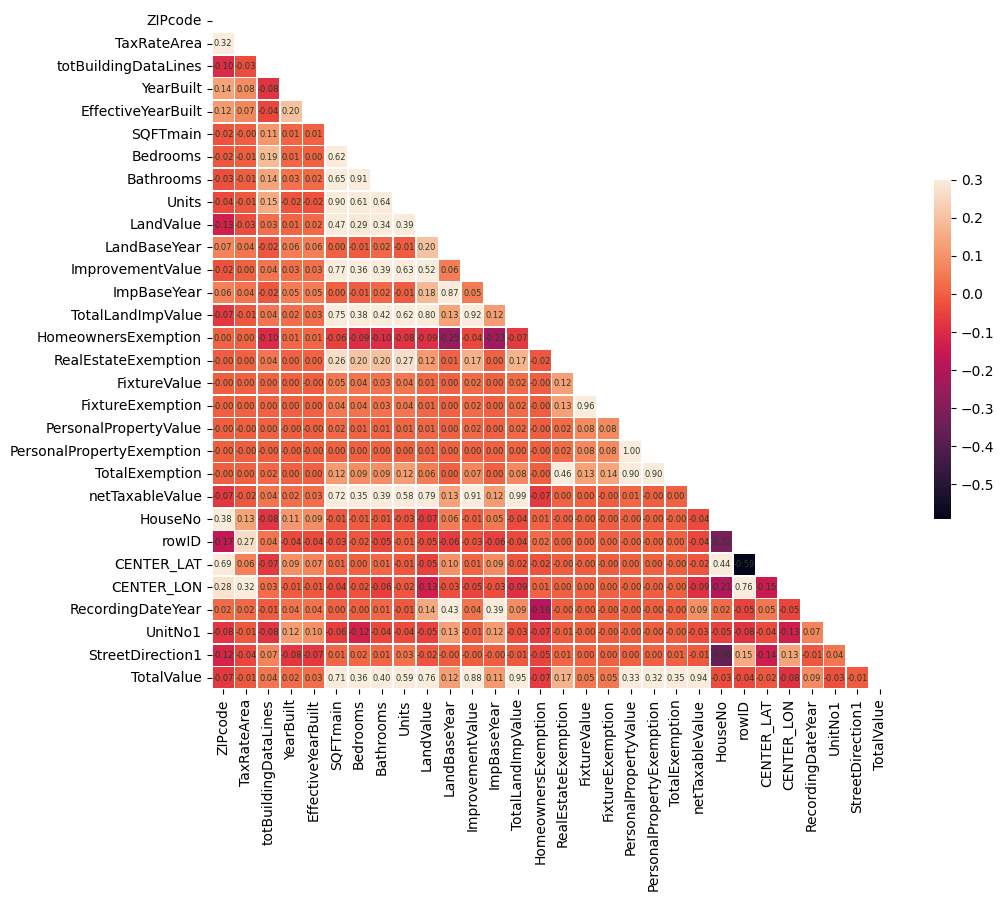

In [ ]:
#sns.heatmap(data=dcorr)
plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=dcorr,
            vmax=0.3,
            annot=True,
            fmt=".2f",
            annot_kws={'size':6,'weight':'normal', 'color':'#253D24'},
            mask=np.triu(np.ones_like(dcorr,dtype=np.bool)),
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5}
           )

In [ ]:
# drop features that may cause data leakage
data.drop(["LandValue", "ImprovementValue", "PersonalPropertyValue", "netTaxableValue",
           "TotalExemption","PersonalPropertyExemption","HomeownersExemption",
           "RealEstateExemption","FixtureExemption","EffectiveYearBuilt", "TaxRateArea", 
           "GeneralUseType", "PropertyUseCode", "TotalLandImpValue", "LandBaseYear", 
           "FixtureValue", "isTaxableParcel", "StreetName", "rowID", "RecordingDateYear", "geo"], axis=1, inplace=True)

In [ ]:
features = data.columns.tolist()
features.remove('TotalValue')
categorical_cols = [i for i in features if is_object_dtype(data[i])]

In [ ]:
data[categorical_cols]

,TaxRateArea_CITY,PropertyType,SpecificUseType,AdministrativeRegion,City
10993,LOS ANGELES,SFR,Single Family Residence,02,LOS ANGELES CA
11045,LOS ANGELES,SFR,Single Family Residence,02,LOS ANGELES CA
11122,SANTA CLARITA,SFR,Single Family Residence,B1,VALENCIA CA
11266,SANTA MONICA,SFR,Single Family Residence,07,SANTA MONICA CA
11361,LOS ANGELES,SFR,Single Family Residence,12,LOS ANGELES CA
...,...,...,...,...,...
2423224,DIAMOND BAR,SFR,Single Family Residence,06,DIAMOND BAR CA
2423227,DIAMOND BAR,SFR,Single Family Residence,06,DIAMOND BAR CA
2423228,unincorporated,SFR,Single Family Residence,11,WALNUT CA
2423229,DIAMOND BAR,CND,Single Family Residence,06,WALNUT CA


In [ ]:
# label encoding
data_encoder = data.copy()
for col in categorical_cols:
  le = preprocessing.LabelEncoder()
  le.fit(data_encoder[col])
  data_encoder[col] = le.transform(data_encoder[col])
  res_col = {}
  for cl in le.classes_:
    res_col.update({cl:le.transform([cl])[0]})

In [ ]:
data_encoder

,ZIPcode,TaxRateArea_CITY,PropertyType,SpecificUseType,totBuildingDataLines,YearBuilt,SQFTmain,Bedrooms,Bathrooms,Units,ImpBaseYear,TotalValue,AdministrativeRegion,HouseNo,City,CENTER_LAT,CENTER_LON,UnitNo1,StreetDirection1
10993,91304,48,3,6,1,1963,1650,4,2,1,2011,368094.0,0,8222,308,34.21875,-118.6250,0,0
11045,91436,48,3,6,1,1959,1696,3,2,1,2013,741740.0,0,15565,308,34.15625,-118.5000,0,0
11122,91354,72,3,6,1,1997,2784,5,3,1,2009,797085.0,21,23240,620,34.46875,-118.5625,0,0
11266,90404,74,3,6,1,1941,855,2,1,1,2011,674650.0,5,1308,533,34.03125,-118.5000,0,0
11361,90011,48,3,6,1,1907,1613,3,1,1,2009,237927.0,9,215,308,34.00000,-118.2500,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423224,91789,22,3,6,1,1983,2781,4,3,1,2009,928619.0,4,1971,124,34.00000,-117.8750,0,0
2423227,91789,22,3,6,1,1987,1546,3,3,1,2011,637955.0,4,20825,124,33.96875,-117.8750,0,1
2423228,91789,88,3,6,1,1976,2614,3,3,1,2013,648451.0,8,20430,646,34.00000,-117.8750,0,0
2423229,91789,22,0,6,1,1987,912,2,2,1,2021,455000.0,4,20715,646,33.96875,-117.8750,1,1


In [ ]:
features = data.columns.tolist()
features.remove('TotalValue')
X = data[features]

features1 = data_encoder.columns.tolist()
features1.remove('TotalValue')
X_encoder = data_encoder[features1]

In [ ]:
y = pd.DataFrame(data[target])
y_encoder = pd.DataFrame([data_encoder[target]])

In [ ]:
y_encoder = pd.DataFrame(np.array(y_encoder).reshape(2043273,1))

In [ ]:
# Split feature and target datasets
# As we run the whole dataset, we realize how impossible it is to train such a large data
# Thus, we plan to use 5% subsample, and then apply K-fold validation by dividing subsample into train and test set
X_sub, X_un, y_sub, y_un = train_test_split(X, y, test_size=0.95, random_state=445)
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=445)
X_sub_e, X_un_e, y_sub_e, y_un_e = train_test_split(X_encoder, y_encoder, test_size=0.95, random_state=445)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_sub_e, y_sub_e, test_size=0.2, random_state=445)

# Original Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=445)
#X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_encoder, y_encoder, test_size=0.2, random_state=445)

In [ ]:
print(f'Train dataset has {X_train.shape[0]} rows and {X_train.shape[1]} columns.')
print(f'Test dataset has {X_test.shape[0]} rows and {X_test.shape[1]} columns.')

Train dataset has 81730 rows and 18 columns.
Test dataset has 20433 rows and 18 columns.


In [ ]:
print(f'Train dataset has {X_train_e.shape[0]} rows and {X_train_e.shape[1]} columns.')
print(f'Test dataset has {X_test_e.shape[0]} rows and {X_test_e.shape[1]} columns.')

Train dataset has 81730 rows and 18 columns.
Test dataset has 20433 rows and 18 columns.


In [ ]:
X_train.head()

,ZIPcode,TaxRateArea_CITY,PropertyType,SpecificUseType,totBuildingDataLines,YearBuilt,SQFTmain,Bedrooms,Bathrooms,Units,ImpBaseYear,AdministrativeRegion,HouseNo,City,CENTER_LAT,CENTER_LON,UnitNo1,StreetDirection1
2041109,90670,SANTA FE SPRINGS,SFR,Single Family Residence,1,1953,1044,3,1,1,2002,11,10839,SANTA FE SPRINGS CA,33.93750,-118.0625,0,0
2326700,91780,TEMPLE CITY,SFR,Single Family Residence,1,1956,896,2,1,1,1975,05,9649,TEMPLE CITY CA,34.09375,-118.0625,0,0
467598,91387,SANTA CLARITA,SFR,Single Family Residence,1,2005,3215,4,3,1,2010,B1,17758,CANYON COUNTRY CA,34.40625,-118.4375,0,0
45939,91301,AGOURA HILLS,SFR,Single Family Residence,1,1980,2628,3,3,1,2016,02,28830,AGOURA HILLS CA,34.15625,-118.7500,0,0
1927468,90501,TORRANCE,SFR,Single Family Residence,1,1955,1420,4,2,1,1997,14,2272,TORRANCE CA,33.81250,-118.3125,0,1


In [ ]:
X_train_e.head()

,ZIPcode,TaxRateArea_CITY,PropertyType,SpecificUseType,totBuildingDataLines,YearBuilt,SQFTmain,Bedrooms,Bathrooms,Units,ImpBaseYear,AdministrativeRegion,HouseNo,City,CENTER_LAT,CENTER_LON,UnitNo1,StreetDirection1
2041109,90670,73,3,6,1,1953,1044,3,1,1,2002,8,10839,527,33.93750,-118.0625,0,0
2326700,91780,80,3,6,1,1956,896,2,1,1,1975,3,9649,596,34.09375,-118.0625,0,0
467598,91387,72,3,6,1,2005,3215,4,3,1,2010,21,17758,79,34.40625,-118.4375,0,0
45939,91301,0,3,6,1,1980,2628,3,3,1,2016,0,28830,9,34.15625,-118.7500,0,0
1927468,90501,81,3,6,1,1955,1420,4,2,1,1997,10,2272,612,33.81250,-118.3125,0,1


Detect multicollinearity

In [ ]:
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_temp = sm.add_constant(X_train_e)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

#delete 5 variables that contain exemption in the name for the extreme large vif value

    VIF Factor              features
0     531281.8                 const
1          3.0               ZIPcode
2          2.3      TaxRateArea_CITY
3          3.6          PropertyType
4          1.5       SpecificUseType
5          1.3  totBuildingDataLines
6          1.1             YearBuilt
7          4.7              SQFTmain
8          6.9              Bedrooms
9          7.1             Bathrooms
10         4.0                 Units
11         1.0           ImpBaseYear
12         1.4  AdministrativeRegion
13         1.8               HouseNo
14         2.2                  City
15         2.7            CENTER_LAT
16         1.7            CENTER_LON
17         3.6               UnitNo1
18         1.2      StreetDirection1


In [ ]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


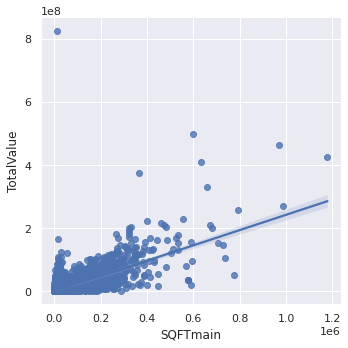

In [ ]:
sns.set(style='darkgrid', color_codes=True)
sns.lmplot(x="SQFTmain", y="TotalValue", data=data)

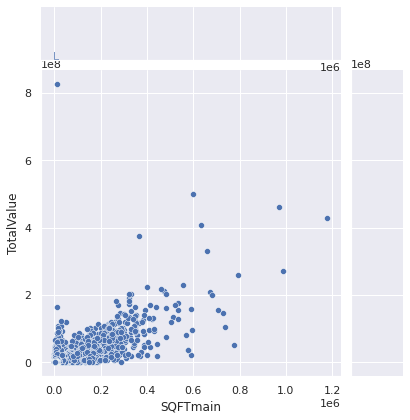

In [ ]:
ax2 = sns.jointplot(x="SQFTmain", y="TotalValue", data=data)

# Model fitting

In [ ]:
# Cross Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Model Function
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Scoring
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import time

###Linear Regression

In [ ]:
# Training 
lm = LinearRegression()
lm.fit(X_train_e, y_train_e)
y_pred_linear_train = lm.predict(X_train_e)
r2_score_linear_train = r2_score(y_train_e, y_pred_linear_train)
print('r2_score (train): ', r2_score_linear_train)

# Cross Validation
for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator = lm, X = X_train_e, y = y_train_e, cv = 10, scoring = score).mean())

r2_score (train):  0.49142821881792653
r2 : 0.450008891698792
neg_root_mean_squared_error : -987330.1173234705


###Polynomial regression

In [ ]:
# Training
poly_features = PolynomialFeatures(degree = 2)
## transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train_e) 
## fit the transformed features to Linear Regression
poly_features.fit(X_train_poly, y_train_e)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_e)
y_pred_poly_train = poly_model.predict(poly_features.fit_transform(X_train_e))
r2_score_poly_train = r2_score(y_train_e, y_pred_poly_train)
print('r2_score (train): ', r2_score_poly_train)

# Cross Validation
for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator = poly_model, X = X_train_poly, y = y_train_e, cv = 10, scoring = score).mean())

r2_score (train):  0.7095436277803706
r2 : -0.2778333936933562
neg_root_mean_squared_error : -1392741.723422321


###Ridge Regression

In [ ]:
# 5-fold cross-validation
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}


kflod = StratifiedKFold(n_splits=5, shuffle=True, random_state=445)
start = time.time()
ridge_model = GridSearchCV(Ridge(), params, cv=5, verbose=0, return_train_score=True)
ridge_model.fit(X_train_e,y_train_e)
print("best_parms:{0}\nbest_score:{1}".format(ridge_model.best_params_, ridge_model.best_score_))
print('GridSearchCV process use %.2f seconds'%(time.time()-start))

best_parms:{'alpha': 0.0001}
best_score:0.43279357141722236
GridSearchCV process use 5.08 seconds


In [ ]:
# Training model with best parameters
ridge_best = ridge_model.best_estimator_

for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator=ridge_best, X=X_train_e, y=y_train_e, cv=kflod, scoring=score).mean())

r2 : 0.4347776308020796
neg_root_mean_squared_error : -1006127.9507495007


###Lasso Regression

In [ ]:
# 5-fold cross-validation

params = {'alpha': [0.00001,0.0001,0.001, 0.01,1.0,2]}

kflod = StratifiedKFold(n_splits=5, shuffle=True, random_state=445)
start = time.time()
lasso_model = GridSearchCV(Lasso(), params, cv=5, verbose=0, return_train_score=True)
lasso_model.fit(X_train_e,y_train_e)
print("best_parms:{0}\nbest_score:{1}".format(lasso_model.best_params_, lasso_model.best_score_))
print('GridSearchCV process use %.2f seconds'%(time.time()-start))

best_parms:{'alpha': 2}
best_score:0.4327936848945435
GridSearchCV process use 15.28 seconds


In [ ]:
# Training model with best parameters
lasso_best = lasso_model.best_estimator_

for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator=lasso_best, X=X_train_e, y=y_train_e, cv=kflod, scoring=score).mean())

r2 : 0.4347780750198475
neg_root_mean_squared_error : -1006127.6001131417


### Decision Free Regression

In [ ]:
# Hyper parameters range intialization
param_dt = {"max_depth" : [3,5,7,9,11,13,15,20,25,30],
            "min_samples_leaf":[2,4,6,7,8,9,10],
            "max_leaf_nodes":[None,10,30,50,70,90]}
# 5-fold cross-validation
kflod = StratifiedKFold(n_splits=5, shuffle=True, random_state=445)
start = time.time()
dt_model = GridSearchCV(DecisionTreeRegressor(), param_dt, cv=5, verbose=0, return_train_score=True)
dt_model.fit(X_train_e,y_train_e)
print("best_parms:{0}\nbest_score:{1}".format(dt_model.best_params_, dt_model.best_score_))
print('GridSearchCV process use %.2f seconds'%(time.time()-start))

best_parms:{'max_depth': 15, 'max_leaf_nodes': None, 'min_samples_leaf': 7}
best_score:0.6311894820063353
GridSearchCV process use 616.42 seconds


In [ ]:
# Training model with best parameters
dt_best = dt_model.best_estimator_

for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator=dt_best, X=X_train_e, y=y_train_e, cv=kflod, scoring=score).mean())

r2 : 0.6341482940654878
neg_root_mean_squared_error : -816976.1033039733


### Random Forest Regression

In [ ]:
# Setting hyper-parameters
param_rf = {'max_depth':[5,7,9,11],
            'n_estimators':[50,100,200,500]}
# 5-fold cross-validation
start = time.time()
rf_model = GridSearchCV(RandomForestRegressor(), param_rf, cv=kflod)
rf_model.fit(X_train_e, y_train_e)
print("best_parms:{0}\nbest_score:{1}".format(rf_model.best_params_, rf_model.best_score_))
print('GridSearchCV process use %.2f seconds'%(time.time()-start))

best_parms:{'max_depth': 11, 'n_estimators': 100}
best_score:0.6933700508162934
GridSearchCV process use 3955.89 seconds


In [ ]:
# Training model with best parameters
rf_best = rf_model.best_estimator_

for score in ["r2", "neg_root_mean_squared_error"]:
  print(score, ":", cross_val_score(estimator=rf_best, X=X_train_e, y=y_train_e, cv=kflod, scoring=score).mean())

r2 : 0.6919158836575308
neg_root_mean_squared_error : -749013.0886757958


In [ ]:
rf_best.fit(X_train_e, y_train_e)


RandomForestRegressor(max_depth=11)

In [ ]:
y_predict = rf_best.predict(X_test_e)

In [ ]:
np.savetxt('predict_price.csv', y_predict, delimiter = ',') 

In [ ]:
np.savetxt('y_price.csv', y_test_e, delimiter = ',') 

In [ ]:
X_test_e.to_csv('Features.csv')